In [32]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [33]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Getting dataset from kaggle (Uncomment if you wish to check however we have kept local copy)

In [34]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("goubeast/age-prediction-av")
#print("Path to dataset files:", path)

In [35]:
#! ls data/train/old


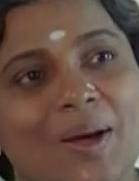

In [36]:
path = './data/train/old'
#name = '82.headshot.jpg'
name = '10019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [37]:
img = load_img(fullname, target_size=(200, 200))
x = np.array(img)
x.shape

(200, 200, 3)

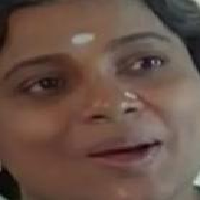

In [38]:
img

Model from scratch

In [39]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [40]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │    20,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,073,473 (76.57 MB)

 Trainable params: 20,073,473 (76.57 MB)

 Non-trainable params: 0 (0.00 B)

Transfer learning: Reusing Imagenet model

In [42]:
from keras.applications.xception import Xception

In [43]:
# modify create model function
def create_model(learning_rate=0.001, size_inner=100):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # 2 classes
  outputs = keras.layers.Dense(2)(inner)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model


In [44]:
train_dir = 'data/train'
test_dir = 'data/test'

#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [45]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [46]:
train_generator.class_indices

{'old': 0, 'young': 1}

In [47]:
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


In [48]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [49]:
model = create_model()

In [50]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7897 - loss: 0.4562 - val_accuracy: 0.8601 - val_loss: 0.3289
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8779 - loss: 0.2888 - val_accuracy: 0.8663 - val_loss: 0.3033
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8922 - loss: 0.2549 - val_accuracy: 0.8654 - val_loss: 0.3057
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9247 - loss: 0.1971 - val_accuracy: 0.8873 - val_loss: 0.2743
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9356 - loss: 0.1679 - val_accuracy: 0.8733 - val_loss: 0.3178
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9463 - loss: 0.1387 - val_accuracy: 0.8882 - val_loss: 0.2911
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9546 - loss: 0.1189 - val_accuracy: 0.8961 - val_loss: 0.2941
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9702 - loss: 0.0853 - 

Find best learning rate for Adam optimizer

In [51]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = create_model(learning_rate=lr)
    history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    )
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.7868 - loss: 0.4633 - val_accuracy: 0.8317 - val_loss: 0.3808
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8523 - loss: 0.3507 - val_accuracy: 0.8619 - val_loss: 0.3299
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8675 - loss: 0.3278 - val_accuracy: 0.8637 - val_loss: 0.3146
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8867 - loss: 0.2828 - val_accuracy: 0.8689 - val_loss: 0.3060
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9028 - loss: 0.2573 - val_accuracy: 0.8742 - val_loss: 0.2989
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8980 - loss: 0.2550 - val_accuracy: 0.8865 - val_loss: 0.2858
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9212 - loss: 0.2184 - val_accuracy: 0.8825 - val_loss: 0.2811
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9268 - loss: 0.

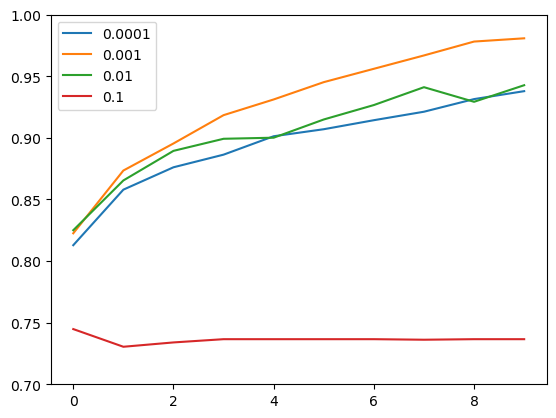

In [52]:
for lr, hist in scores.items():
  plt.plot(
      hist['accuracy'],
      label=lr
  )

plt.ylim(0.70, 1)
plt.legend()

In [53]:
# Best learning rate
learning_rate = 0.001

Find the best size for inner layer

In [54]:
scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = create_model(learning_rate, size_inner=size)
    history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    )
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.7419 - loss: 0.5011 - val_accuracy: 0.8203 - val_loss: 0.3989
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8464 - loss: 0.3830 - val_accuracy: 0.8588 - val_loss: 0.3699
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8604 - loss: 0.3565 - val_accuracy: 0.8610 - val_loss: 0.3435
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8855 - loss: 0.3111 - val_accuracy: 0.8724 - val_loss: 0.3222
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8968 - loss: 0.2772 - val_accuracy: 0.8715 - val_loss: 0.3102
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9007 - loss: 0.2682 - val_accuracy: 0.8733 - val_loss: 0.3113
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9047 - loss: 0.2530 - val_accuracy: 0.8641 - val_loss: 0.3398
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9142 - loss: 0.2378

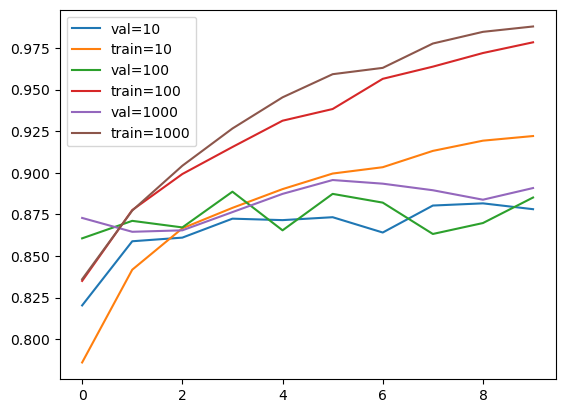

In [55]:
for size, hist in scores.items():
  plt.plot(
      hist['val_accuracy'],
      label=('val=%s' % size),
  )
  plt.plot(
      hist['accuracy'],
      label=('train=%s' % size)
  )

  plt.legend()

In [56]:
# Best size
size_inner = 100

Data Augmentation

In [57]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [58]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [59]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [60]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


In [61]:
# Create checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'#max monitor variable
)

In [62]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7786 - loss: 0.6204

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 180ms/step - accuracy: 0.7787 - loss: 0.6199 - val_accuracy: 0.8729 - val_loss: 0.3043
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.8435 - loss: 0.3599 - val_accuracy: 0.8615 - val_loss: 0.3475
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 62s 181ms/step - accuracy: 0.8489 - loss: 0.3528 - val_accuracy: 0.8751 - val_loss: 0.3069
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8506 - loss: 0.3388 - val_accuracy: 0.8724 - val_loss: 0.3087
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.8624 - loss: 0.3286 - val_accuracy: 0.8575 - val_loss: 0.3893
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.8591 - loss: 0.3213 - val_accuracy: 0.8658 - val_loss: 0.3344
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.8757 - loss: 0.2937 - val_accuracy: 0.8715 - val_loss: 0.3066
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.8775 - loss: 0.3021 - val

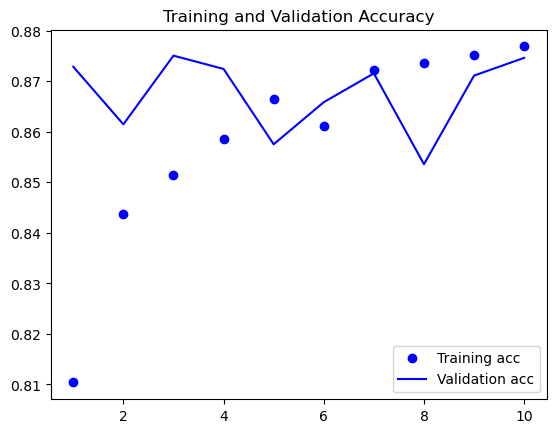

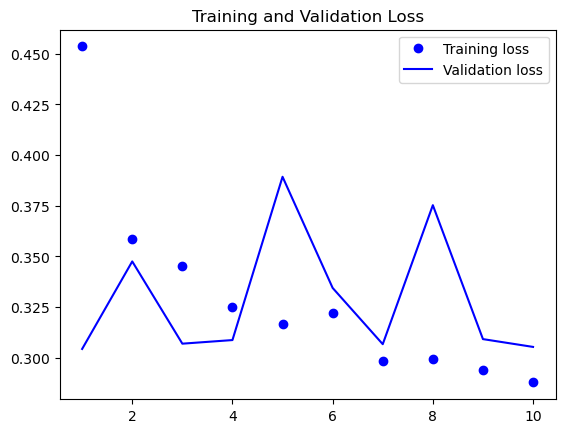

In [63]:
acc_aug = history.history['accuracy']
val_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [64]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

np.float64(0.3287494510412216)

In [65]:
val_acc_aug[5:10]

[0.8658483028411865,
 0.8715475797653198,
 0.8535729646682739,
 0.8711091876029968,
 0.8746163845062256]

In [66]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

np.float64(0.8673388838768006)

Using a saved model via checkpoint

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [68]:
model = keras.models.load_model('xception_v1_08_0.893.keras')

In [69]:
model.evaluate(validation_generator)

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8800 - loss: 0.5655


[0.5033975839614868, 0.8925909399986267]

In [70]:
path = 'data/test/young/10056.jpg'
img = load_img(path, target_size=(200, 200))

In [71]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape

(1, 200, 200, 3)

In [72]:
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [73]:
pred[0]

array([-1.584364 ,  1.1029187], dtype=float32)

In [74]:
import tensorflow as tf

probabilities = tf.nn.softmax(pred[0]).numpy()
print(probabilities)

[0.06372795 0.936272  ]


Convert model to TF-Lite

In [75]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdf2dhejp/assets


INFO:tensorflow:Assets written to: /tmp/tmpdf2dhejp/assets


Saved artifact at '/tmp/tmpdf2dhejp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139903753822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753824848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753824080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753825040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753825616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753823696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753824656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753823888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753825808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753826576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753826

W0000 00:00:1737913702.483635    1251 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737913702.483664    1251 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-26 17:48:22.484124: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdf2dhejp
2025-01-26 17:48:22.497140: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-26 17:48:22.497167: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdf2dhejp
I0000 00:00:1737913702.612196    1251 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-26 17:48:22.632581: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-26 17:48:23.482238: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdf2dhejp
2025-01-26 17:48:23.668402: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 